## Sentiment model

### Find the best lag of sentiment scores

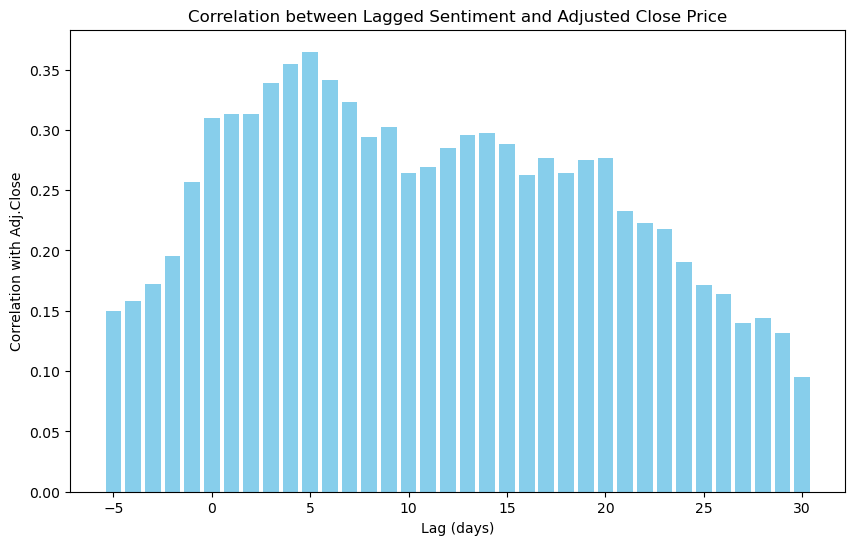

The best lag is 5 days with a correlation of 0.3648


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the merged data
file_path = '../data/AAPL_Merge_2024-07-10.csv'
df = pd.read_csv(file_path)

# Calculate correlations for lags from -5 to 30
lags = range(-5, 31)
correlations = [df['Adj.Close'].corr(df['avg_sentiment'].shift(lag)) for lag in lags]

# Plot histogram of correlations
plt.figure(figsize=(10, 6))
plt.bar(lags, correlations, color='skyblue')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation with Adj.Close')
plt.title('Correlation between Lagged Sentiment and Adjusted Close Price')
plt.show()

# Find the best lag with the highest correlation
best_lag = lags[np.argmax(correlations)]
best_correlation = max(correlations)

print(f"The best lag is {best_lag} days with a correlation of {best_correlation:.4f}")

### BiLSTM forecasting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

# Load the merged data
file_path = '../data/AAPL_Merge_2024-07-10.csv'
df = pd.read_csv(file_path)

# Fill missing values
df.fillna(method='pad', inplace=True)
df.fillna(0, inplace=True)  # Fill remaining NaNs with 0

# Create the lagged sentiment feature
df['lagged_sentiment'] = df['avg_sentiment'].shift(5)
df.fillna(0, inplace=True)  # Fill remaining NaNs after shifting

# Selecting relevant columns
data = df[['Adj.Close', 'Volume', 'SMA_50', 'GSPC.Adjusted', 'lagged_sentiment']]

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on (80% of the data)
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Scale the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Scale the 'Adj.Close' data to be values between 0 and 1 for inverse transformation later
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(df[['Adj.Close']].values)

# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train data sets
sequence_length = 60
x_train = []
y_train = []

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, :])
    y_train.append(train_data[i, 0])  # Use only the 'Adj.Close' as the target variable

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Build the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1))

# Compile and Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Polynomial learning rate schedule
def polynomial_decay(epoch, lr, max_epochs=600, initial_lr=0.001, end_lr=0.00001, power=0.8):
    if epoch > max_epochs:
        epoch = max_epochs
    lr = (initial_lr - end_lr) * (1 - epoch / max_epochs) ** power + end_lr
    return lr

epochs = 600
polynomial_lr = LearningRateScheduler(lambda epoch, lr: polynomial_decay(epoch, lr, max_epochs=epochs, initial_lr=1.e-3, end_lr=1.e-5, power=0.8))

# Train the model
with tf.device('/GPU:0'):
    model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=2, callbacks=[polynomial_lr])

/opt/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/h2/h6g6fk252v76pst2bj55kwgw0000gn/T/ipykernel_49140/219310040.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad', inplace=True)


Mean Squared Error (MSE): 7.386874774312942
Mean Absolute Error (MAE): 2.018651144845146


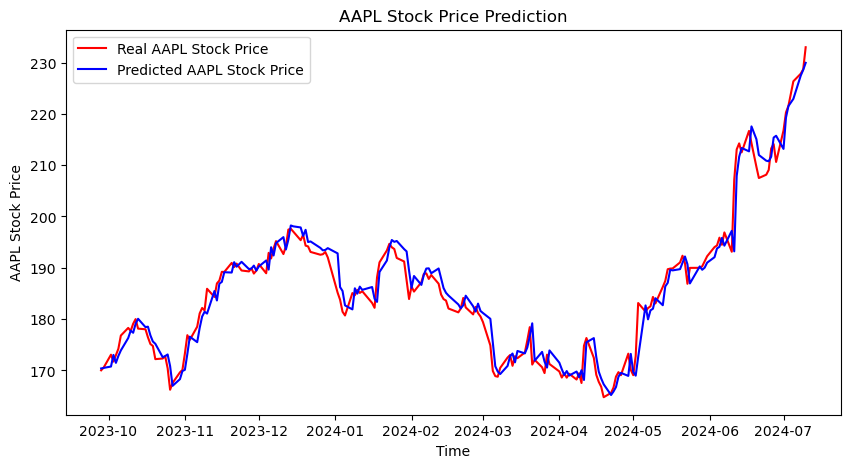

In [ ]:
# Prepare the testing data
test_data = scaled_data[training_data_len - sequence_length:, :]
x_test = []
y_test = df['Adj.Close'][training_data_len:, ].values

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, :])

x_test = np.array(x_test)

# Reshape the data into the shape accepted by the RNN
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Predict the values for the test data
predictions = model.predict(x_test, verbose=0)

# Perform inverse transformation on the predicted values
predicted_adj_close = close_scaler.inverse_transform(predictions).flatten()

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, predicted_adj_close)
mae = mean_absolute_error(y_test, predicted_adj_close)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)

df['Date'] = pd.to_datetime(df['Date'])

# Plot the actual vs predicted values
plt.figure(figsize=(8,5))
plt.plot(df['Date'][training_data_len:, ], y_test, color = 'red', label = 'Real AAPL Stock Price')
plt.plot(df['Date'][training_data_len:, ], predicted_adj_close, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()

# Save the plot as a high-quality PNG file
# plt.savefig('AAPL_Stock_Price_Prediction_2024.png', format='png', dpi=200)